In [1]:
from pprint import pprint
# importing functions and modules useful for launching simulations
from main import get_options, get_min_mean_free_path, init_particles_in_system
from main import square, thruster
from main import CollisionHandler
from main import scipy_integrate_solve_ivp, rk4, euler_explicit

In [2]:
debug = True

In [3]:
# defining paths to cfg 
main = 'cfg_files/main.cfg'
system = 'cfg_files/tube.cfg' # square thruster tube
saving = 'cfg_files/saving.cfg'
simulation = 'cfg_files/simulation.cfg'

cfg_path_dict = {
    'main':main,
    'system':system,
    'saving':saving,
    'simulation':simulation
}

In [4]:
options = get_options(cfg_path_dict)
if(debug): pprint(options)

{'main': {'id_test': 1,
          'particles_densities': [1e+20],
          'particles_mean_number_per_cell': [100],
          'particles_radius': [2e-10],
          'particles_types': ['I'],
          'speed_param1': [300.0],
          'speed_param2': [100.0],
          'speed_type': ['gaussian'],
          'system_type': 'square'},
 'saving': {'path': PosixPath('/home/paul/Documents/projects/Neutralisation_Faisceau_ions_negatifs_propulsion_satellite/results'),
            'period': 10},
 'simulation': {'dt': 0.25, 'number_of_steps': 10, 'scheme': 'euler_explicit'},
 'square': {'factor': 1.0, 'lz': 0.1, 'size': [3, 10]}}


## Building system

In [5]:
min_mean_free_path = get_min_mean_free_path(radiuses = options['main']['particles_radius'], particles_densities = options['main']['particles_densities'])
if(debug): print('Min mean free path : {} m.'.format(min_mean_free_path))

Min mean free path : 0.01406744243995478 m.


In [6]:
system_type = options['main']['system_type']

if(system_type=='square'):
    system = square(options[system_type], min_mean_free_path)
    zone = None
    offset = [0,0]
    
elif(system_type=='thruster'):
    system = thruster(options[system_type], min_mean_free_path)
    zone = system.get_zone()
    offset = system.get_offset()

## Initializing particles

Space size : [0.04220232731986434, 0.1406744243995478, 0.1]
Resolution : [3, 10]
{'first particles': ['I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.025,0.105) m with speed (186.278,129.701) '
                     'm/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.011,0.101) m with speed (556.804,385.015) '
                     'm/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.039,0.081) m with speed (220.392,272.888) '
                     'm/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.018,0.084) m with speed (231.032,370.775) '
                     'm/s',
                     'I particule of charge 0 C and mass 2.35800283e-25 kg in '
                     'position (0.001,0.082) m with speed (249.63,302.401) '
                  

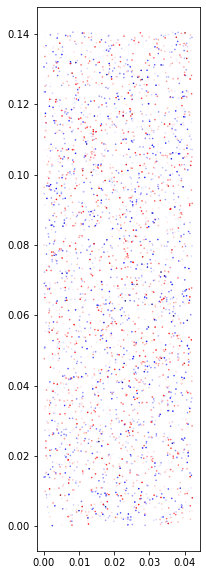

In [7]:
lx, ly, lz = system.get_size()
res_x, res_y = system.get_space_resolutions()
if(debug):
    print('Space size : {}'.format(system.get_size()))
    print('Resolution : {}'.format(system.get_space_resolutions()))
list_particles, vmean_exp = init_particles_in_system(**options['main'], space_size = [lx,ly], space_resolution=[res_x, res_y], zone = zone, offsets = offset, verbose = False, debug = False)
# adding particles to the grid
for particle in list_particles:
    system.add(particle)

    # TODO : do as Lui said - don't save it this way. (its okay for now)
if(system_type=='thruster'):
    #system.set_sparsed_space()
    pass
if(debug):
    pprint({
        'mean speed':vmean_exp,
        'first particles':[part.to_string() for part in list_particles][:5],
        'walls':system.get_walls()
    })
system.plot()

## Preping simulation

In [8]:
# update function
import numpy as np

if(system_type=='thruster'):
    from dolfin import Point

    def f(Y,t,m,q,zone,E):
        '''
        Renvoie la dérivée de Y en y (en faisant un bilan des forces notamment) pr être entré dans RK4
        Y=[x, y, z, vx, vy, vz] ce n'est pas le Y de liste_Y
        '''
        Ex, Ey = E.split(deepcopy=True)
        vx=Y[3]
        vy=Y[4]
        vz=Y[5]
        if zone.inside(Point(Y[0],Y[1])):
            ax = (1/m) * q * Ex(Y[0], Y[1])
            ay = (1/m) * q * Ey(Y[0], Y[1])
        else :
            ax = 0  #utile si les ki sont hors du mesh,
            ay = 0
        az=0
        return np.array([vx, vy, vz, ax, ay, az])
    
    args = [system.get_zone(), system.get_E()]
    
elif(system_type=='square'):
    def f(Y,t,m,q):
        vx=Y[3]
        vy=Y[4]
        vz=Y[5]

        ax = 0 
        ay = 0
        az = 0
        return np.array([vx, vy, vz, ax, ay, az])
    
    args = []

# DSMC params
N_particles_real = [int(density*lx*ly*lz) for density in options['main']['particles_densities']] # this is the REAL number of particles
N_particles_simu = [int(nb*res_x*res_y) for nb in options['main']['particles_mean_number_per_cell']]
Ne = [i/j for i, j in zip(N_particles_real,N_particles_simu)]

# TODO : see the adaptations for the DMSC with several species of particles

mean_speed = 300
DSMC_params = {
    'vr_max' : 2*mean_speed,
    'effective_diameter':  2*options['main']['particles_radius'][0], # for now
    'Ne' : Ne[0], # this is the number of real particles one simulated particle represents.
    'cell_volume' : lx*ly*lz/(res_x*res_y), # since we are in 2D I don't really know what to add here actually... For now, I add the 3rd dimension rough size, that is l3
    'mean_particles_number_per_cell': sum(options['main']['particles_mean_number_per_cell']) # we don't account for the type
}

if(debug):
    pprint([N_particles_real, N_particles_simu, Ne, DSMC_params])
    
    
use_particles_collisions = False
use_DSMC = True

simu = options['simulation']
if(simu['scheme']=='euler_explicit'):
    integration_scheme = euler_explicit # scipy_integrate_solve_ivp , rk4 , euler_explicit
    # TODO : make a function get_scheme(str)
    
# TODO : include system instead of everything else here.
collisionHandler = CollisionHandler(list_particles, system.get_walls(), f, eta = 0, p = 0, use_particles_collisions = use_particles_collisions, \
        use_DSMC = use_DSMC, grid = system.get_grid(), DSMC_params = DSMC_params, integration_scheme=integration_scheme)

[[59367881040432272],
 [3000],
 [19789293680144.09],
 {'Ne': 19789293680144.09,
  'cell_volume': 1.9789293680144093e-05,
  'effective_diameter': 4e-10,
  'mean_particles_number_per_cell': 100,
  'vr_max': 600}]


## Launching Simulation

In [9]:
from tqdm import tqdm

min_mean_free_time = min_mean_free_path/mean_speed
dt = simu['dt']*min_mean_free_time
t = 0
for k in tqdm(range(simu['number_of_steps'])):
    #if(debug): print("\nStep {} over {}...\n".format(k+1, MAX_INTEGRATION_STEP))
    collisionHandler.step(dt, t, args)
    t+=dt
    #if(save_test and (k%saving_period==0 or k == MAX_INTEGRATION_STEP-1)): # we are saving last frame
    #    print("Cool")
        # TODO : add params with "callback functions"
        # that we would do each time (or initialize them before in some way)
        # if it requires some initializing (parameters to set etc.)
        # data_analyser.save_everything_to_one_csv()
        # print(collisionHandler.save_collisions_matrix(name = "test_"+str(id_test)+"_collision_matrix", iteration = k))
    #if(debug): print("\nElapsed  time for {} iterations with {} particules and with {} data structure : {}".format(MAX_INTEGRATION_STEP, N_particles_simu, dtype, round(time()-elapsed_time,3)))

100%|██████████| 10/10 [02:48<00:00, 16.89s/it]


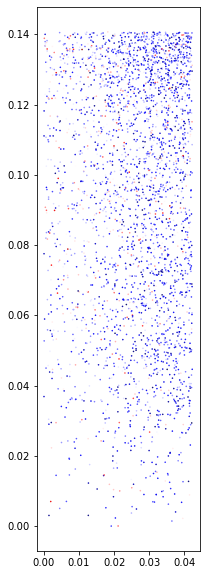

In [10]:
system.plot()